In [3]:
import sys
sys.path.insert(0, '..')
import os
import glob
from filament import filament
import datetime
import cmocean
import logging
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from importlib import reload
import matplotlib as mpl
reload(filament)
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="f")

In [4]:
logger = logging.getLogger("Sentinel3_chloro")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 1

In [30]:
figdir = "../figures/chloro/"
datadir = "/data/Sentinel3/S3B_OL_2_WFR____20200721T10363..._222_2340_MAR_O_NT_002.SEN3"
datadir2 = "/data/Sentinel3/S3B_OL_2_WFR____20200721T10393..._222_2520_MAR_O_NT_002.SEN3"

## Regional domains

In [12]:
mediumdomain = (-19., -6., 25., 35.)
smalldomain = (-15., -9., 27., 33.)
tinydomain = (-12., -9., 29.5, 32.)
canarydomain = (-18.5, -13., 25., 29.5)
coordinates = mediumdomain

In [15]:
def load_sentinel3_chloro(datadir):
    
    lon = None
    lat = None
    chloro = None
    
    if os.path.exists(datadir):
        datafile = os.path.join(datadir, "chl_oc4me.nc")
        coordfile = os.path.join(datadir, "geo_coordinates.nc")
        
        if os.path.exists(datafile) & os.path.exists(coordfile):
    
            with netCDF4.Dataset(coordfile, "r") as nc:
                lon = nc.variables["longitude"][:]
                lat = nc.variables["latitude"][:]
            with netCDF4.Dataset(datafile, "r") as nc:
                chloro = nc.variables["CHL_OC4ME"][:]
        else:
            logger.warning("Data file missing")
    else:
        logger.error("Data directory does not exist")
            
    return lon, lat, chloro    

In [31]:
lon, lat, c = load_sentinel3_chloro(datadir)
lon2, lat2, c2 = load_sentinel3_chloro(datadir2)

### Projection

In [ ]:
m = Basemap(projection='merc', llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            lat_ts=0.5 * (lat.mean()), resolution='h')

In [39]:
mall = Basemap(projection='merc', llcrnrlon=min(lon2.min(), lon.min()), llcrnrlat=min(lat2.min(), lat.min()),
            urcrnrlon=max(lon2.max(), lon.max()), urcrnrlat=max(lat2.max(), lat.max()),
            lat_ts=0.5 * (lat2.mean()), resolution='i')

In [ ]:
def get_domain_rec(lon, lat):
    lonrect = np.concatenate((lon[:,0].compressed(),
                              lon[-1,:].compressed(),
                              np.flipud(lon[:,-1].compressed()),
                              np.flipud(lon[0,:].compressed())))
    latrect = np.concatenate((lat[:,0].compressed(),
                              lat[-1,:].compressed(),
                              np.flipud(lat[:,-1].compressed()),
                              np.flipud(lat[0,:].compressed())))
                             
    return lonrect, latrect

In [43]:
lonr, latr = get_domain_rec(lon, lat)
lonr2, latr2 = get_domain_rec(lon2, lat2)

In [44]:
lon.shape, lon2.shape

((4090, 4865), (4091, 4865))

### Domains
Adjust ii, jj, kk and ll to ensure the selected domain falls where you want.

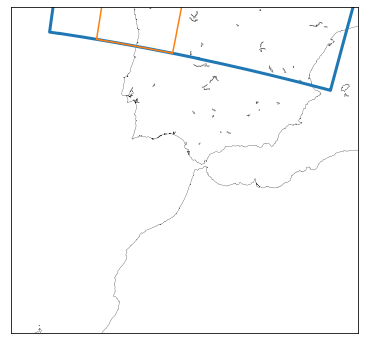

In [45]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

ii = 3000
jj = 4090
kk = 800
ll = 2100
lonr2, latr2 = get_domain_rec(lon[ii:jj, kk:ll], lat[ii:jj, kk:ll])
lonr3, latr3 = get_domain_rec(lon2[ii:jj, kk:ll], lat2[ii:jj, kk:ll])

mall.plot(lonr, latr, latlon=True, linewidth=3)
mall.plot(lonr2, latr2, latlon=True)
m.drawcoastlines(linewidth=0.25, color="k")
plt.show()

## Plot

In [27]:
chloro = filament.Chloro()
chloro.lon = lon[ii:jj, kk:ll]
chloro.lat = lat[ii:jj, kk:ll]
chloro.field = c[ii:jj, kk:ll]

/home/ctroupin/Software/PythonEnvs/Filament3.8/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


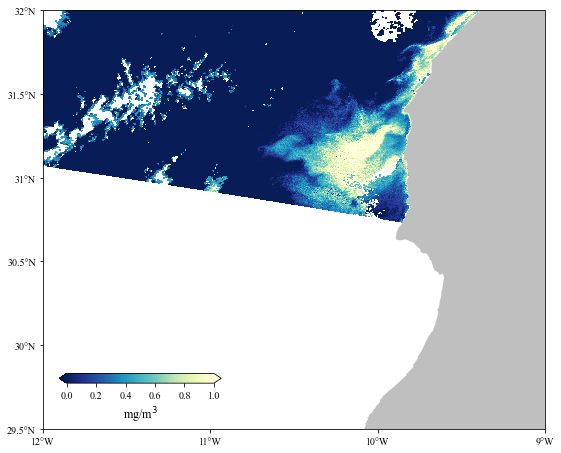

In [28]:
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(111, projection=myproj)
#plt.title(datetime.datetime.strftime(chloro.date, "%Y-%m-%d"), fontsize=16)

chloro.add_to_plot(fig, ax, domain=tinydomain, cmap=plt.cm.YlGnBu_r,
                clim=[0.0, 1.], vis=False,
                cbarloc=[0.15, 0.25, 0.25, 0.015],
                alpha=1, extend="both")

ax.add_feature(coast, linewidth=.2, color=".75")
filament.decorate_map(ax, tinydomain, np.arange(-12., -7., 1.), 
                      np.arange(25., 35., .5))
#plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches="tight",
#           facecolor="w", transparent=False)
plt.show()
plt.close()